#Setting up the environment

In [107]:
import matplotlib.pyplot as plt
import nltk
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from collections import Counter
import random 
from random import randrange
from random import sample
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import feature_extraction, manifold
import seaborn as sn
nltk.download('gutenberg')
nltk.download('punkt')
nltk.download('stopwords')
stop_words=set(stopwords.words("english"))

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#Importing Data

In [108]:
files = nltk.corpus.gutenberg.fileids() #array that contains all files retreived from gutenberg
texts = []
print(files)

def get_texts(files, texts): # function to get random books to draw samples from
  count = 5 # 4 books to be used
  prev_vals = [0,5,6,10,16] #5 books from different authors that we believe have the same or similar genres
  for i in range(len(prev_vals)):
    texts.append(files[prev_vals[i]])

get_texts(files, texts)
print(texts)
print(len(files))


['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']
['austen-emma.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'chesterton-thursday.txt', 'shakespeare-macbeth.txt']
18


#Preprocessing and Data Cleansing


In [109]:
#This function parses the text that we imported along with the number of partitions (Rows) and number of words per each partition (W)
#We can change these numbers each time to evaluate the performance of the classifiers  

def get_df(texts,Rows,W): #function that takes the list of books and returns a df with 200 cleaned samples for each book
  filtered_sentences = []
  labels = []
  for i in range(len(texts)):
    text = nltk.corpus.gutenberg.raw(texts[i]) #get the book
    text = text.lower()
    tokenized_word=nltk.word_tokenize(text) #tokenize the words
    cleaned_words = [word for word in tokenized_word if word.isalnum()] #clean the words from symbols and keep alphanumeric characters instead of using regex
    filtered_words=[]
    for w in cleaned_words:# Clean the words yet again from stop words.
        if w not in stop_words:
            filtered_words.append(w)
    #filtered_sentences.append(' '.join(filtered_words[0:4]))
    random_numbers = []
    for c in range(Rows):
      while True: # To stay in loop and change random number if it was used before
        x = randrange(0,len(filtered_words)-W) #generate random number from 0 to length of string - 100 (to be able to take last 100 words)
        if (x not in random_numbers): # make sure the number was not used before
          random_numbers.append(x) #add random number to list
          filtered_sentences.append(' '.join(filtered_words[x:x+W])) #add 100 words from random position to array.
          labels.append(texts[i][0:-4]) #append the label of the book while removing last 4 characters ".txt"
          break
        
  print(len(filtered_sentences))
  print(len(filtered_words))
  df = pd.DataFrame({'label': labels, 'sample': filtered_sentences})
  
  return df, filtered_sentences
df, s = get_df(texts,200,30) #Changing the number of partitions and the number of words in every partition will change the whole performance of the experiment.
print(len(s[0]))
print(len(nltk.word_tokenize((s[0]))))


1000
9613
221
30


In [110]:
df

,label,sample
0,austen-emma,grateful wonder acquit weston must say think g...
1,austen-emma,see every body found well worth seeing weston ...
2,austen-emma,smile shake head spoke much looked mr seemed i...
3,austen-emma,one else pause gave time reflect going introdu...
4,austen-emma,said something quite new know new set irish me...
...,...,...
995,shakespeare-macbeth,come gentle lord sleeke rugged lookes bright i...
996,shakespeare-macbeth,net lime pitfall gin son mother poore birds se...
997,shakespeare-macbeth,growing noble banquo hast lesse deseru must kn...
998,shakespeare-macbeth,within porter knocking indeede man porter hell...


In [111]:
df.describe

<bound method NDFrame.describe of                    label                                             sample
0            austen-emma  grateful wonder acquit weston must say think g...
1            austen-emma  see every body found well worth seeing weston ...
2            austen-emma  smile shake head spoke much looked mr seemed i...
3            austen-emma  one else pause gave time reflect going introdu...
4            austen-emma  said something quite new know new set irish me...
..                   ...                                                ...
995  shakespeare-macbeth  come gentle lord sleeke rugged lookes bright i...
996  shakespeare-macbeth  net lime pitfall gin son mother poore birds se...
997  shakespeare-macbeth  growing noble banquo hast lesse deseru must kn...
998  shakespeare-macbeth  within porter knocking indeede man porter hell...
999  shakespeare-macbeth  rosse angus attendants king castle hath pleasa...

[1000 rows x 2 columns]>

#Splitting the data

In [112]:
sample = df.loc[:,'sample']
sample_x = sample.values

label = df.loc[:,'label']
label_x = label.values
X_train, X_test, y_train, y_test = train_test_split(sample_x, label_x, test_size=0.5, random_state=42)

#Getting misclassified records function

In [113]:
def get_misclassified(pred):
# Correcting the index of x,y_test to get the misclassified records
  y_test_right_index = []
  X_test_right_index =[]
  for item in y_test:
    y_test_right_index.append(item)


  for item1 in X_test:
    X_test_right_index.append(item1)
  # print(X_test_right_index)
#creating an array of the mis-classified records
  misclassified_records=[]
  misclassified_label = []
  right_label= []
  for i in range(len(pred)):
    if (pred[i]!= y_test_right_index[i]):
      misclassified_records.append(X_test_right_index[i])
      misclassified_label.append(pred[i])
      right_label.append(y_test_right_index[i])
  df=pd.DataFrame({"misclassified_records":misclassified_records,"misclassified_label":misclassified_label,"right_label":right_label })
  return df
 

#Confusion matrix and Classification report Plotting function 

In [114]:
def performance(y,y_predict):
    print('Confusion Matrix\n')
    labels=['austen-emma', 'bryant-stories', 'burgess-busterbrown', 'chesterton-thursday', 'shakespeare-macbeth']
    hm=sn.heatmap(confusion_matrix(y,y_predict), annot=True)
    plt.show()
    print('Classification Report\n')
    clf_report = classification_report(y,y_predict,
                                   labels=labels,
                                
                                   output_dict=True)
    sn.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)

#Feature Engineering trnasforming text data to BOW, TF-IDF, and n-gram

## BOW transformation

In [115]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_train_counts.shape
X_test_counts= count_vect.transform(X_test)
X_test_counts.shape
# #print(X_train_counts)

(500, 4323)

## TF-IDF Transformation

In [116]:
from sklearn.feature_extraction.text import TfidfTransformer
#vectoriztion before claculating the TF-IDF 
vectorizer = TfidfVectorizer()
X_train_counts= vectorizer.fit_transform(X_train)
#claculating the TF-IDF values
tfidf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tfidf = tfidf_transformer.transform(X_train_counts)
X_train_tfidf.shape

#Transforming the test set as well
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
X_test_tfidf.shape

#getting the keywords frequency
# dict(zip(vectorizer.get_feature_names(), X_train_tfidf.toarray()[0]))


(500, 4323)

## n-gram Transformation

In [117]:
count_vect_ngram = CountVectorizer(ngram_range=(3,3))
X_train_ngram = count_vect_ngram.fit_transform(X_train)
X_train_ngram.shape
X_test_ngram = count_vect_ngram.transform(X_test)
X_test_ngram.shape

(500, 12605)

#Naive bayes

##Using naive bayes using TF-IDF


In [118]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [119]:

docs_new = ['And five couple enough make worth stand Five couple nothing one', 'Let Light see black deepe desires The']
X_new_counts = count_vect.transform(docs_new)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

predicted = clf.predict(X_new_tfidf)
# print(predicted)
for doc, category in zip(docs_new, predicted):
     print('%r => %s' % (doc, [category]))

'And five couple enough make worth stand Five couple nothing one' => ['chesterton-thursday']
'Let Light see black deepe desires The' => ['shakespeare-macbeth']


Confusion Matrix



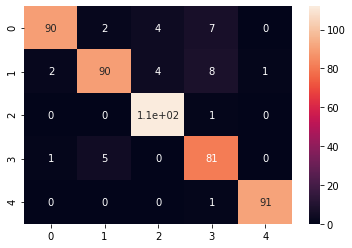

Classification Report



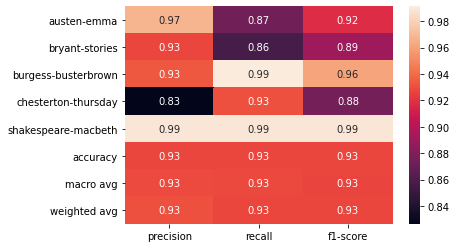

In [120]:
y_test_transformed_tfidf_nv= clf.predict(X_test_tfidf)
performance(y_test,y_test_transformed_tfidf_nv)

In [121]:
from sklearn.model_selection import cross_val_score #cross validation for Naive bayes using TF-IDF
scores = cross_val_score(clf, X_train_tfidf, y_train, cv=10)
scores
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.94 (+/- 0.06)


##Training a model using naive bayes algorithm and BOW 

In [122]:
from sklearn.naive_bayes import MultinomialNB
clf2 = MultinomialNB().fit(X_train_counts, y_train)
docs_new = ['And five couple enough make worth stand Five couple nothing one', 'Let Light see black deepe desires The']
X_new_counts = count_vect.transform(docs_new)

predicted = clf2.predict(X_new_counts)
# print(predicted)
for doc, category in zip(docs_new, predicted):
     print('%r => %s' % (doc, [category]))

'And five couple enough make worth stand Five couple nothing one' => ['chesterton-thursday']
'Let Light see black deepe desires The' => ['shakespeare-macbeth']


Confusion Matrix



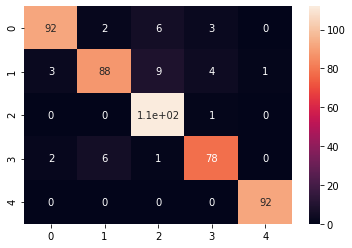

Classification Report



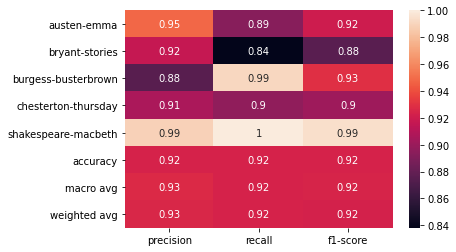

In [123]:
y_test_transformed_tfidf = clf2.predict(X_test_counts)
performance(y_test,y_test_transformed_tfidf)

In [124]:
from sklearn.model_selection import cross_val_score #cross validation for Naive bayes using BOW
scores = cross_val_score(clf2, X_train_counts, y_train, cv=10)
scores
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.94 (+/- 0.06)


##Training a using naive bayes and n-gram transformation

In [125]:
from sklearn.naive_bayes import MultinomialNB
clf_ngram_naivebayes = MultinomialNB().fit(X_train_ngram, y_train)
docs_new = ['And five couple enough make worth stand Five couple nothing one', 'Let Light see black deepe desires The']
X_new_counts =count_vect_ngram.transform(docs_new)
X_new_counts.shape

# predicted = clf_ngram_naivebayes.predict(X_new_counts)
# # print(predicted)
# for doc, category in zip(docs_new, predicted):
#      print('%r => %s' % (doc, [category]))

(2, 12605)

In [126]:
from sklearn.model_selection import cross_val_score #cross validation for Naive bayes using n-gram
scores = cross_val_score(clf_ngram_naivebayes, X_train_ngram, y_train, cv=10)
scores
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.40 (+/- 0.09)


Confusion Matrix



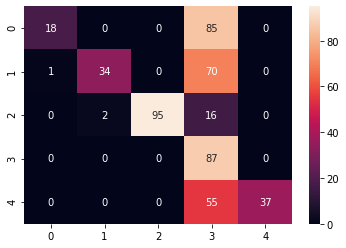

Classification Report



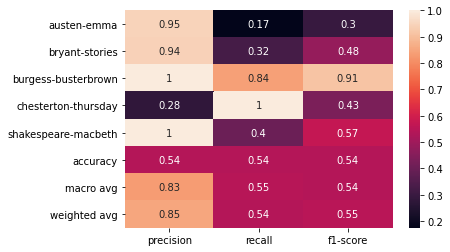

In [127]:
y_test_transformed_ngram_bayes=clf_ngram_naivebayes.predict(X_test_ngram)
performance(y_test,y_test_transformed_ngram_bayes)

#KNN

##KNN using BOW

In [128]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_counts, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [129]:
X_test_transformed = count_vect.transform(X_test)
knn_pred = knn.predict(X_test_transformed)
#knn_pred

Confusion Matrix



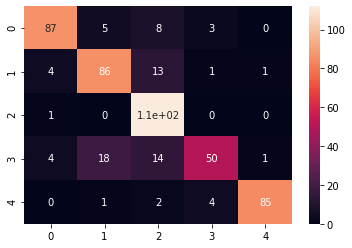

Classification Report



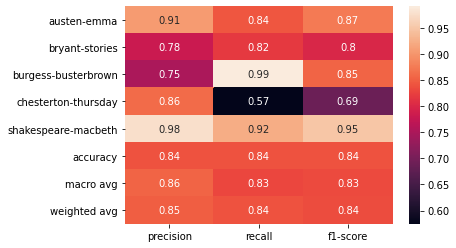

In [130]:

performance(y_test, knn_pred)

In [131]:
from sklearn.model_selection import cross_val_score #cross validation for KNN using BOW
scores = cross_val_score(knn, X_train_counts, y_train, cv=10)
scores
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.85 (+/- 0.11)


##KNN using TF-IDF

In [132]:
knn.fit(X_train_tfidf, y_train)
knn_pred = knn.predict(X_test_transformed)

Confusion Matrix



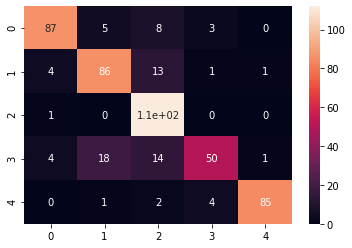

Classification Report



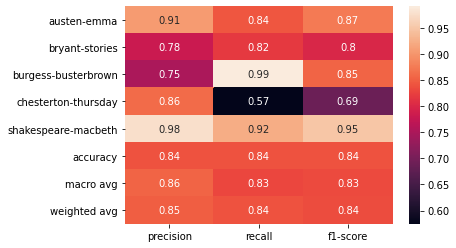

In [133]:
performance(y_test, knn_pred)

In [134]:
scores = cross_val_score(knn, X_train_tfidf, y_train, cv=10) #cross validation for KNN using TF-IDF
scores
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.85 (+/- 0.11)


##KNN using ngram

In [135]:
X_test_ngram = count_vect_ngram.transform(X_test)
knn.fit(X_train_ngram, y_train)
knn_pred = knn.predict(X_test_ngram)

Confusion Matrix



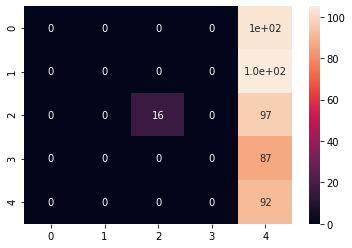

Classification Report



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


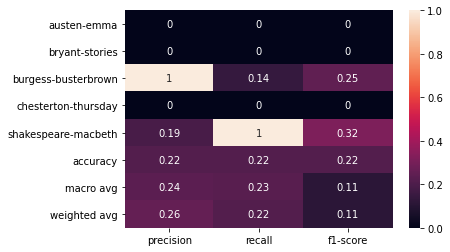

In [136]:
performance(y_test, knn_pred)

In [137]:
scores = cross_val_score(knn, X_train_ngram, y_train, cv=10) #cross validation for KNN using ngrams
scores
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.27 (+/- 0.07)


#SVM

##SVM using BOW

In [138]:
from sklearn import svm

svm = svm.SVC(kernel='linear', C=1)
svm.fit(X_train_counts, y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Confusion Matrix



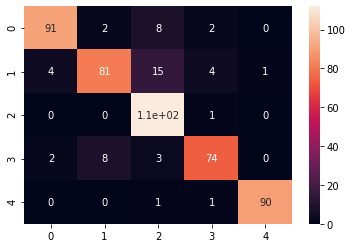

Classification Report



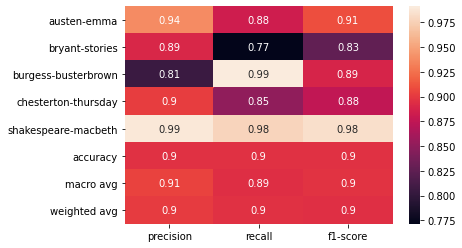

In [139]:
X_test_transformed = count_vect.transform(X_test)
svm_pred = svm.predict(X_test_transformed)

performance(y_test, svm_pred)

In [140]:
scores = cross_val_score(svm, X_train_counts, y_train, cv=10) # cross validation for SVM using BOW
scores
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.94 (+/- 0.07)


##SVM using TF-IDF

Confusion Matrix



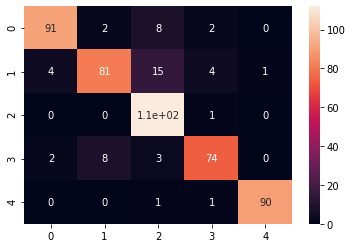

Classification Report



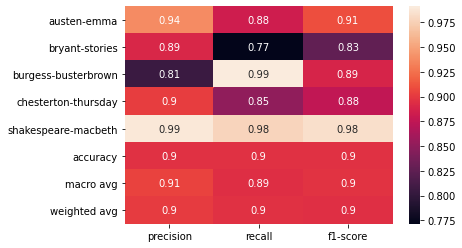

In [141]:
SVM_TFIDF=svm.fit(X_train_tfidf, y_train)
svm_pred = svm.predict(X_test_transformed)
performance(y_test, svm_pred)

In [142]:
scores = cross_val_score(svm, X_train_tfidf, y_train, cv=10) # cross validation for SVM using TF-IDF
scores
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.94 (+/- 0.07)


##SVM using ngram

Confusion Matrix



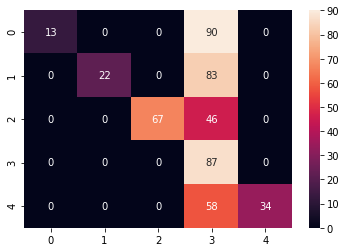

Classification Report



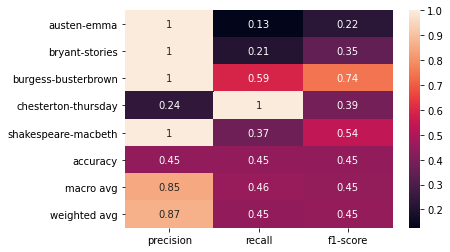

In [143]:
svm.fit(X_train_ngram, y_train)
svm_pred = svm.predict(X_test_ngram)
performance(y_test, svm_pred )

In [144]:
scores = cross_val_score(svm, X_train_ngram, y_train, cv=10) # cross validation for SVM using TF-IDF
scores
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.51 (+/- 0.08)


#Decision Tree

##Decision Tree using BOW

In [145]:
from sklearn import tree
DT = tree.DecisionTreeClassifier()
DT.fit(X_train_counts, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Confusion Matrix



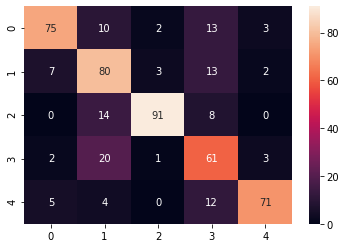

Classification Report



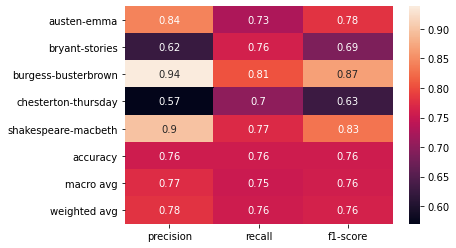

In [146]:
X_test_transformed = count_vect.transform(X_test)
DT_pred = DT.predict(X_test_transformed)
performance(y_test, DT_pred)

In [147]:
scores = cross_val_score(DT, X_train_counts, y_train, cv=10) # cross validation for Decision trees using BOW
scores
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.72 (+/- 0.10)


##Decision Tree using TF-IDF

Confusion Matrix



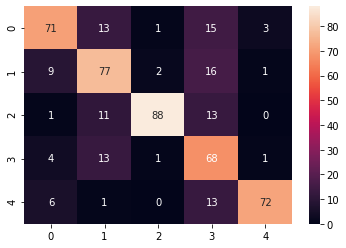

Classification Report



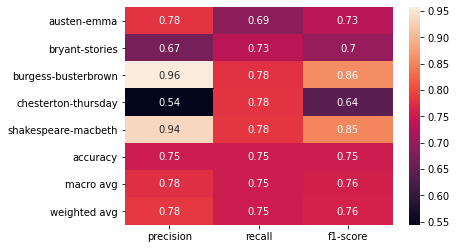

In [148]:
DT.fit(X_train_tfidf, y_train)
X_test_transformed = count_vect.transform(X_test)
DT_pred = DT.predict(X_test_transformed)
performance(y_test, DT_pred)

In [149]:
scores = cross_val_score(DT, X_train_tfidf, y_train, cv=10) # cross validation for Decision trees using TF-IDF
scores
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.73 (+/- 0.10)


##Decision Tree using ngram

Confusion Matrix



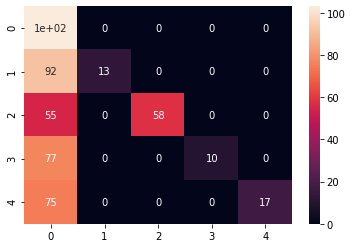

Classification Report



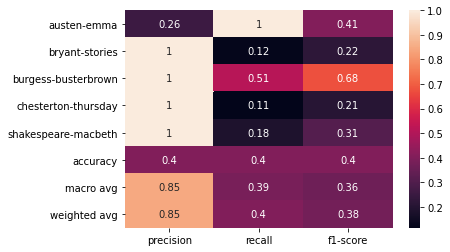

In [150]:
DT.fit(X_train_ngram, y_train)
DT_pred = DT.predict(X_test_ngram)
performance(y_test, DT_pred)

In [151]:
scores = cross_val_score(DT, X_train_ngram, y_train, cv=10) # cross validation for Decision trees using ngram
scores
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.40 (+/- 0.11)


#Missclasification cases






In [152]:
df_misclassified = get_misclassified(y_test_transformed_tfidf_nv)
df_misclassified
#performance(y_test,y_test_transformed_tfidf_nv)

,misclassified_records,misclassified_label,right_label
0,two boots broke sea gravel broad flat stones m...,bryant-stories,chesterton-thursday
1,back friend told fairy said idea said lazy man...,chesterton-thursday,bryant-stories
2,tooth wolfe witches mummey maw gulfe rauin sal...,chesterton-thursday,shakespeare-macbeth
3,new servants performing task diligently watche...,burgess-busterbrown,bryant-stories
4,still greater flutter passed away sat tea part...,chesterton-thursday,austen-emma
5,tail little gingerbread boy fear shall let get...,burgess-busterbrown,bryant-stories
6,full mowers run away run run fast ca catch gin...,burgess-busterbrown,bryant-stories
7,wooden leg room small dark little could seen a...,bryant-stories,chesterton-thursday
8,two evenings ago purpose consult knows thoroug...,chesterton-thursday,austen-emma
9,called harp wall come harp great harp recognis...,shakespeare-macbeth,bryant-stories


In [153]:
df_part = df_misclassified.loc[df_misclassified['right_label'] == "bryant-stories"]
df_part
def describe_error():
    for k in ["chesterton-thursday","austen-emma","burgess-busterbrown","bryant-stories","shakespeare-macbeth"]:
      if len(df_misclassified.loc[df_misclassified['right_label'] == k])>0:
        df_part = df_misclassified.loc[df_misclassified['right_label'] == k]
        records = ' '.join(df_part['misclassified_records'])
        tokenized_word=nltk.word_tokenize(records)
        fdist = FreqDist(tokenized_word)
        print(fdist)
        print(fdist.most_common(2))
        fdist.plot(35,title=("Words that are more likely to be misclassified related to the class: "+ k),cumulative=False)
        plt.show()
df_part

,misclassified_records,misclassified_label,right_label
1,back friend told fairy said idea said lazy man...,chesterton-thursday,bryant-stories
3,new servants performing task diligently watche...,burgess-busterbrown,bryant-stories
5,tail little gingerbread boy fear shall let get...,burgess-busterbrown,bryant-stories
6,full mowers run away run run fast ca catch gin...,burgess-busterbrown,bryant-stories
9,called harp wall come harp great harp recognis...,shakespeare-macbeth,bryant-stories
12,task diligently watched shadow door maidens st...,burgess-busterbrown,bryant-stories
13,chords magic music stole upon air every man fo...,chesterton-thursday,bryant-stories
14,company ducks could talk heart content tortois...,austen-emma,bryant-stories
17,northern forefathers brought dragon ships cros...,chesterton-thursday,bryant-stories
20,felt meant well yes help cried cloud take give...,chesterton-thursday,bryant-stories


##Discribing the frequency of the words in the missclasification cases for each class

<FreqDist with 159 samples and 180 outcomes>
[('one', 3), ('came', 3)]


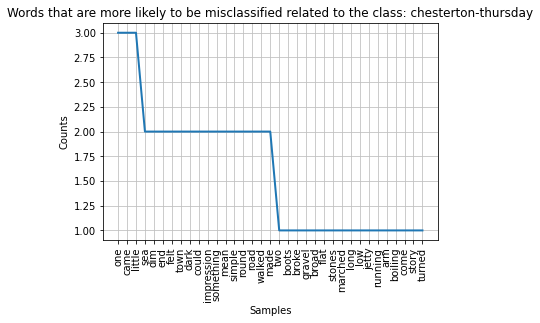

<FreqDist with 296 samples and 390 outcomes>
[('health', 6), ('never', 5)]


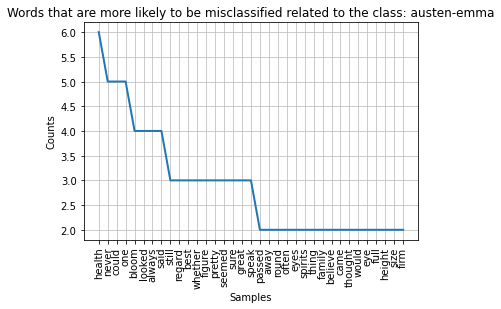

<FreqDist with 21 samples and 30 outcomes>
[('habit', 4), ('bad', 2)]


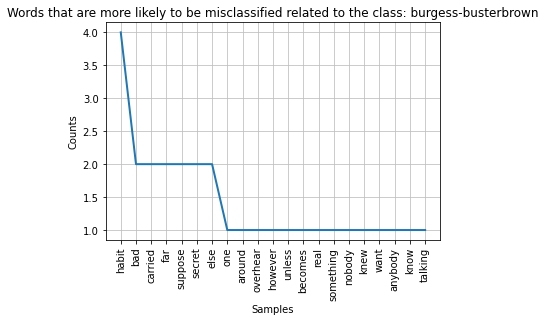

<FreqDist with 298 samples and 450 outcomes>
[('said', 9), ('man', 7)]


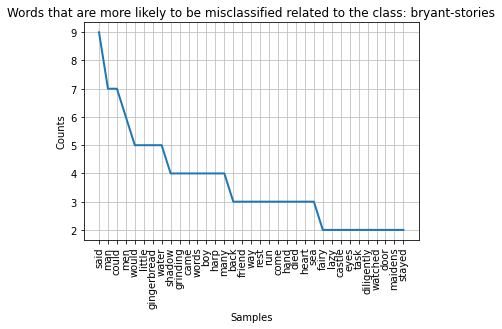

<FreqDist with 30 samples and 30 outcomes>
[('tooth', 1), ('wolfe', 1)]


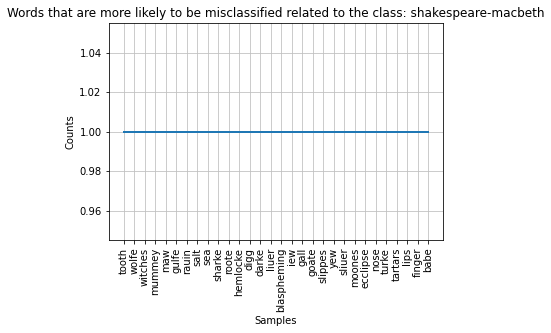

In [154]:
describe_error()


#Calculating the Bias and variance

In [155]:
pip install mlxtend --upgrade --no-deps

Requirement already up-to-date: mlxtend in /usr/local/lib/python3.7/dist-packages (0.18.0)


In [156]:
import mlxtend
import numpy
from sklearn import svm
from mlxtend.data import iris_data
from mlxtend.evaluate import bias_variance_decomp
# X, y = iris_data()
# X_train, X_test, y_train, y_test = train_test_split(X, y,
#                                                     test_size=0.3,
#                                                     random_state=123,
#                                                     shuffle=True,
#                                                     stratify=y) 

y_train_fact = []
y_test_fact = []
for i in range(len(y_train)):
  if (y_train[i] == "austen-emma"):
   y_train_fact.append(0)
  if (y_train[i] == "bryant-stories"):
    y_train_fact.append(1)
  if (y_train[i] == "burgess-busterbrown"):
    y_train_fact.append(2)
  if (y_train[i] == "chesterton-thursday"):
    y_train_fact.append(3)
  if (y_train[i] == "shakespeare-macbeth"):
    y_train_fact.append(4)

for item in y_test:
  if (item == "austen-emma"):
    y_test_fact.append(0)
  if (item == "bryant-stories"):
    y_test_fact.append(1)
  if (item == "burgess-busterbrown"):
    y_test_fact.append(2)
  if (item == "chesterton-thursday"):
    y_test_fact.append(3)
  if (item == "shakespeare-macbeth"):
    y_test_fact.append(4)


y_train_mapped = numpy.array(y_train_fact)
y_test_mapped = numpy.array(y_test_fact)
mse, bias, var = bias_variance_decomp(clf, X_new_tfidf, y_train_mapped, X_test_tfidf, y_test_mapped, loss='mse', num_rounds=100, random_seed=1)
# summarize results
print('MSE: %.3f' % mse)
print('Bias: %.3f' % bias)
print('Variance: %.3f' % var)

MSE: 4.660
Bias: 2.873
Variance: 1.787
